<a href="https://colab.research.google.com/github/Hrithik2212/PyTorch-Deep-Learning-/blob/main/01_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch WorkFlow 

<img src="http://drive.google.com/uc?export=view&id=1Em09kkbzCyhC5wIzThv_XCsfhalpVPhl" align = 'center'>

In [38]:
import torch 
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [39]:
print(torch.__version__)

1.12.0+cu113


## Data Wrangling 

In [40]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [41]:
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [42]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

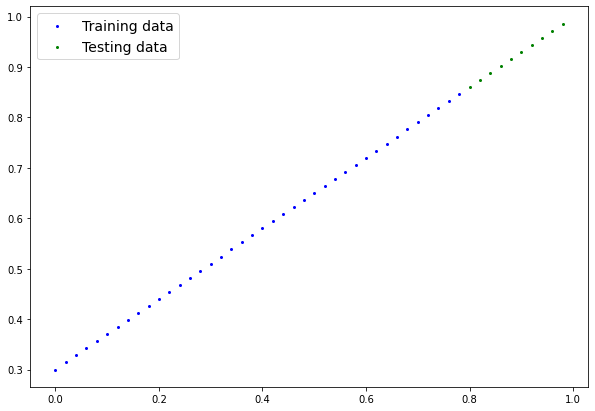

In [43]:
plot_predictions()

## Building the Model 

In [44]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                             requires_grad = True ,
                                             dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1, 
                                        requires_grad=True,
                                        dtype=torch.float))
    
  def forward(self,x : torch.Tensor )->torch.Tensor:
    return x * self.weights + self.bias 

### Testing the Model

In [45]:
torch.manual_seed(42)
model_0 = LinearRegression()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [46]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [47]:
with torch.inference_mode():
  y_pred = model_0.forward(X_test)
y_pred , y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

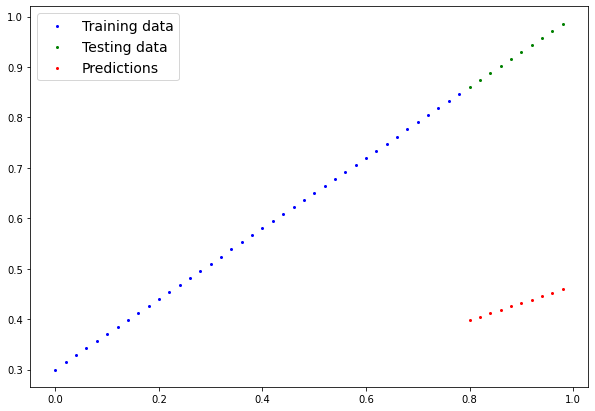

In [48]:
plot_predictions(predictions=y_pred)

## Creating Loss Function and Optimizer 

In [49]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01 )
train_loss_values = []
test_loss_values = []
epoch_count = []

## Building a Training Loop

In [50]:
epochs = 31

for epoch in range(epochs):
    ### Training
    model_0.train()
    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)
    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Progress the optimizer
    optimizer.step()
     ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 


## Plot the loss curves


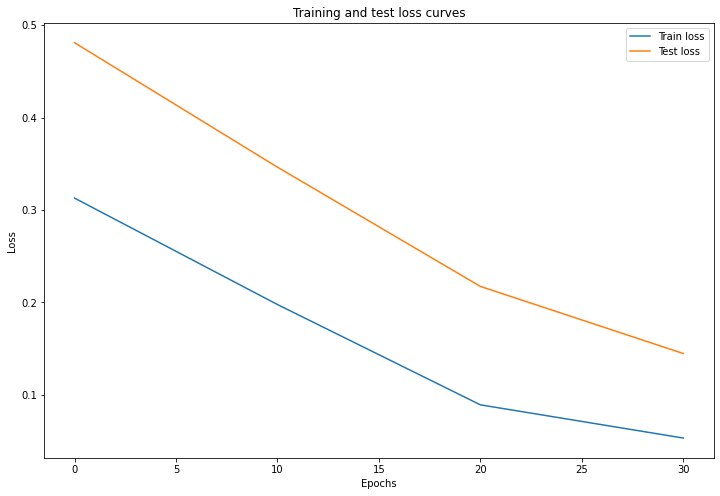

In [51]:
plt.figure(figsize=(12,8))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [53]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.7378],
        [0.7468],
        [0.7558],
        [0.7648],
        [0.7738],
        [0.7829],
        [0.7919],
        [0.8009],
        [0.8099],
        [0.8190]])

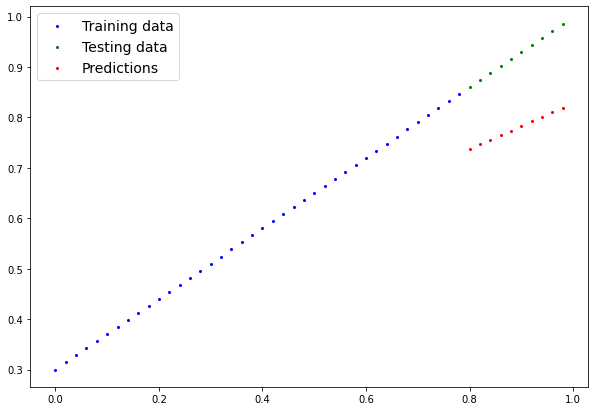

In [54]:
plot_predictions(predictions=y_preds)